## Library imports

In [ ]:
import pandas as pd
import numpy as np
import os
import glob
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50, VGG19
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.utils import resample
from keras.callbacks import EarlyStopping
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from scipy import stats

## Data Analysis of HAM10000 Skin Cancer Dataset

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
5349  HAM_0001235  ISIC_0024530   nv  follow_up  35.0    male   
1258  HAM_0004720  ISIC_0028642  mel      histo  40.0    male   
8065  HAM_0006478  ISIC_0026372   nv      histo  45.0    male   
3344  HAM_0001482  ISIC_0027691   nv  follow_up  45.0  female   
7307  HAM_0004714  ISIC_0033699   nv      histo  30.0  female   
4985  HAM_0006866  ISIC_0030713   nv  follow_up  65.0  female   
1433  HAM_0002509  ISIC_0024732  mel      histo  50.0  female   
7923  HAM_0005601  ISIC_0033441   nv      histo  20.0  female   
6111  HAM_0006495  ISIC_0025215   nv  follow_up  45.0  female   
1385  HAM_0000233  ISIC_0028219  mel      histo  45.0    male   

         localization  label  
5349  lower extremity      5  
1258  lower extremity      4  
8065             back      5  
3344            trunk      5  
7307  upper extremity      5  
4985  upper extremity      5  
1433  upper extr

C:\Users\hp\AppData\Local\Temp\ipykernel_18112\925042307.py:35: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');
C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


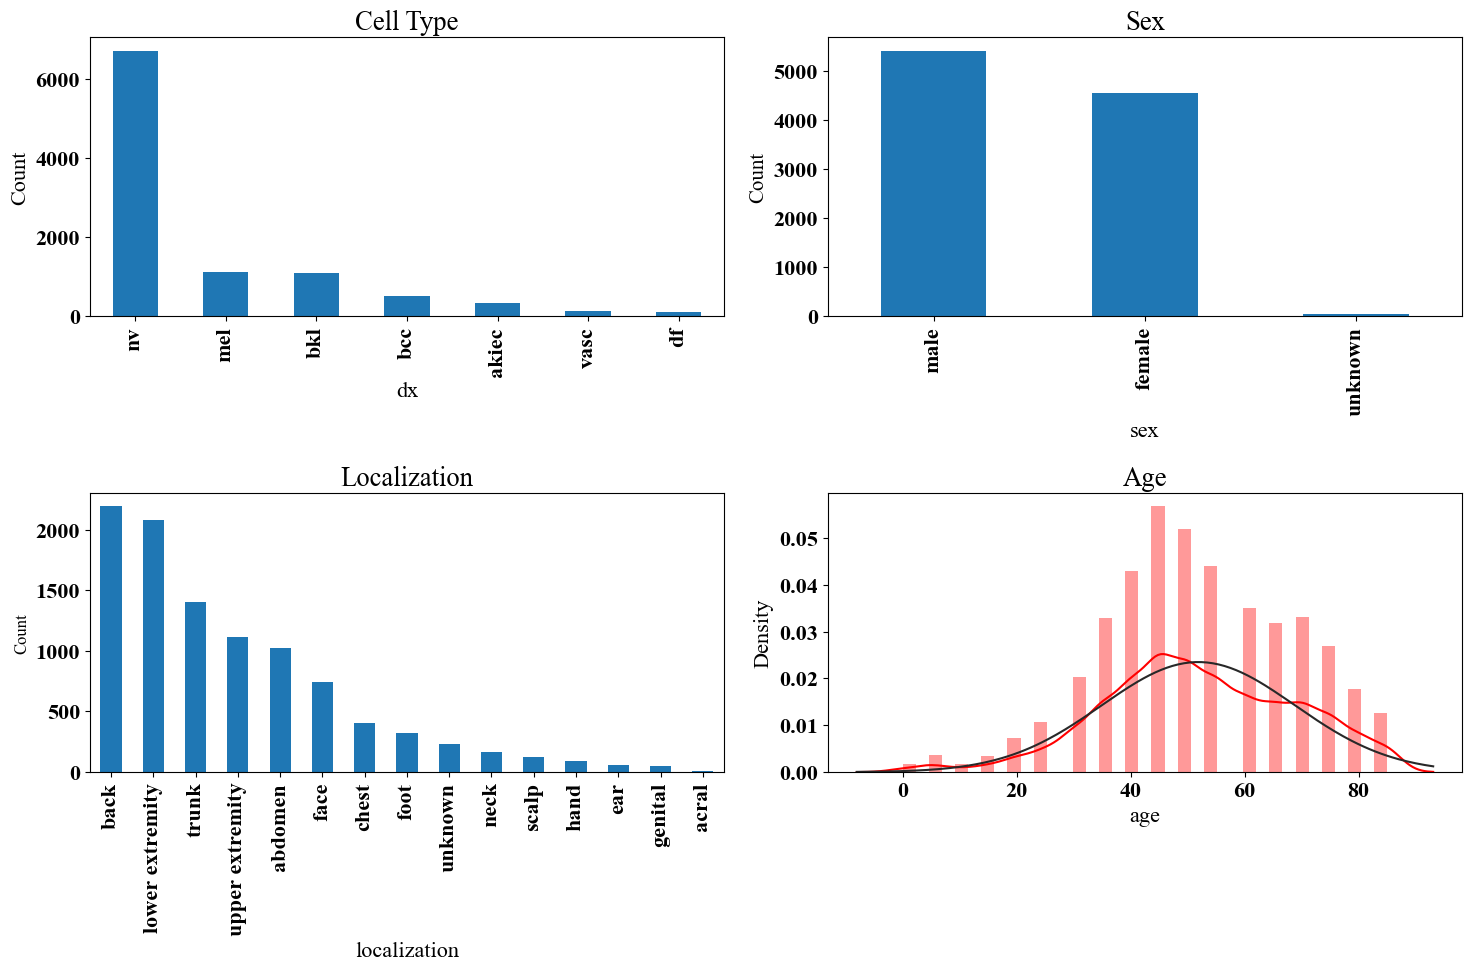

In [35]:

skin_df = pd.read_csv(r'G:\Amrita University\Anomoly_image\Skin/HAM10000_metadata.csv')


SIZE=128

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))
 
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))
# Data distribution visualization
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

## Distribution of data into various classes 

In [ ]:
from sklearn.utils import resample
print(skin_df['label'].value_counts())

#Balance data.
# Many ways to balance data... you can also try assigning weights during model.fit
#Separate each classes, resample, and combine back into single dataframe

df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

n_samples=200 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


## Dataset balancing and visualization

label
5    4693
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


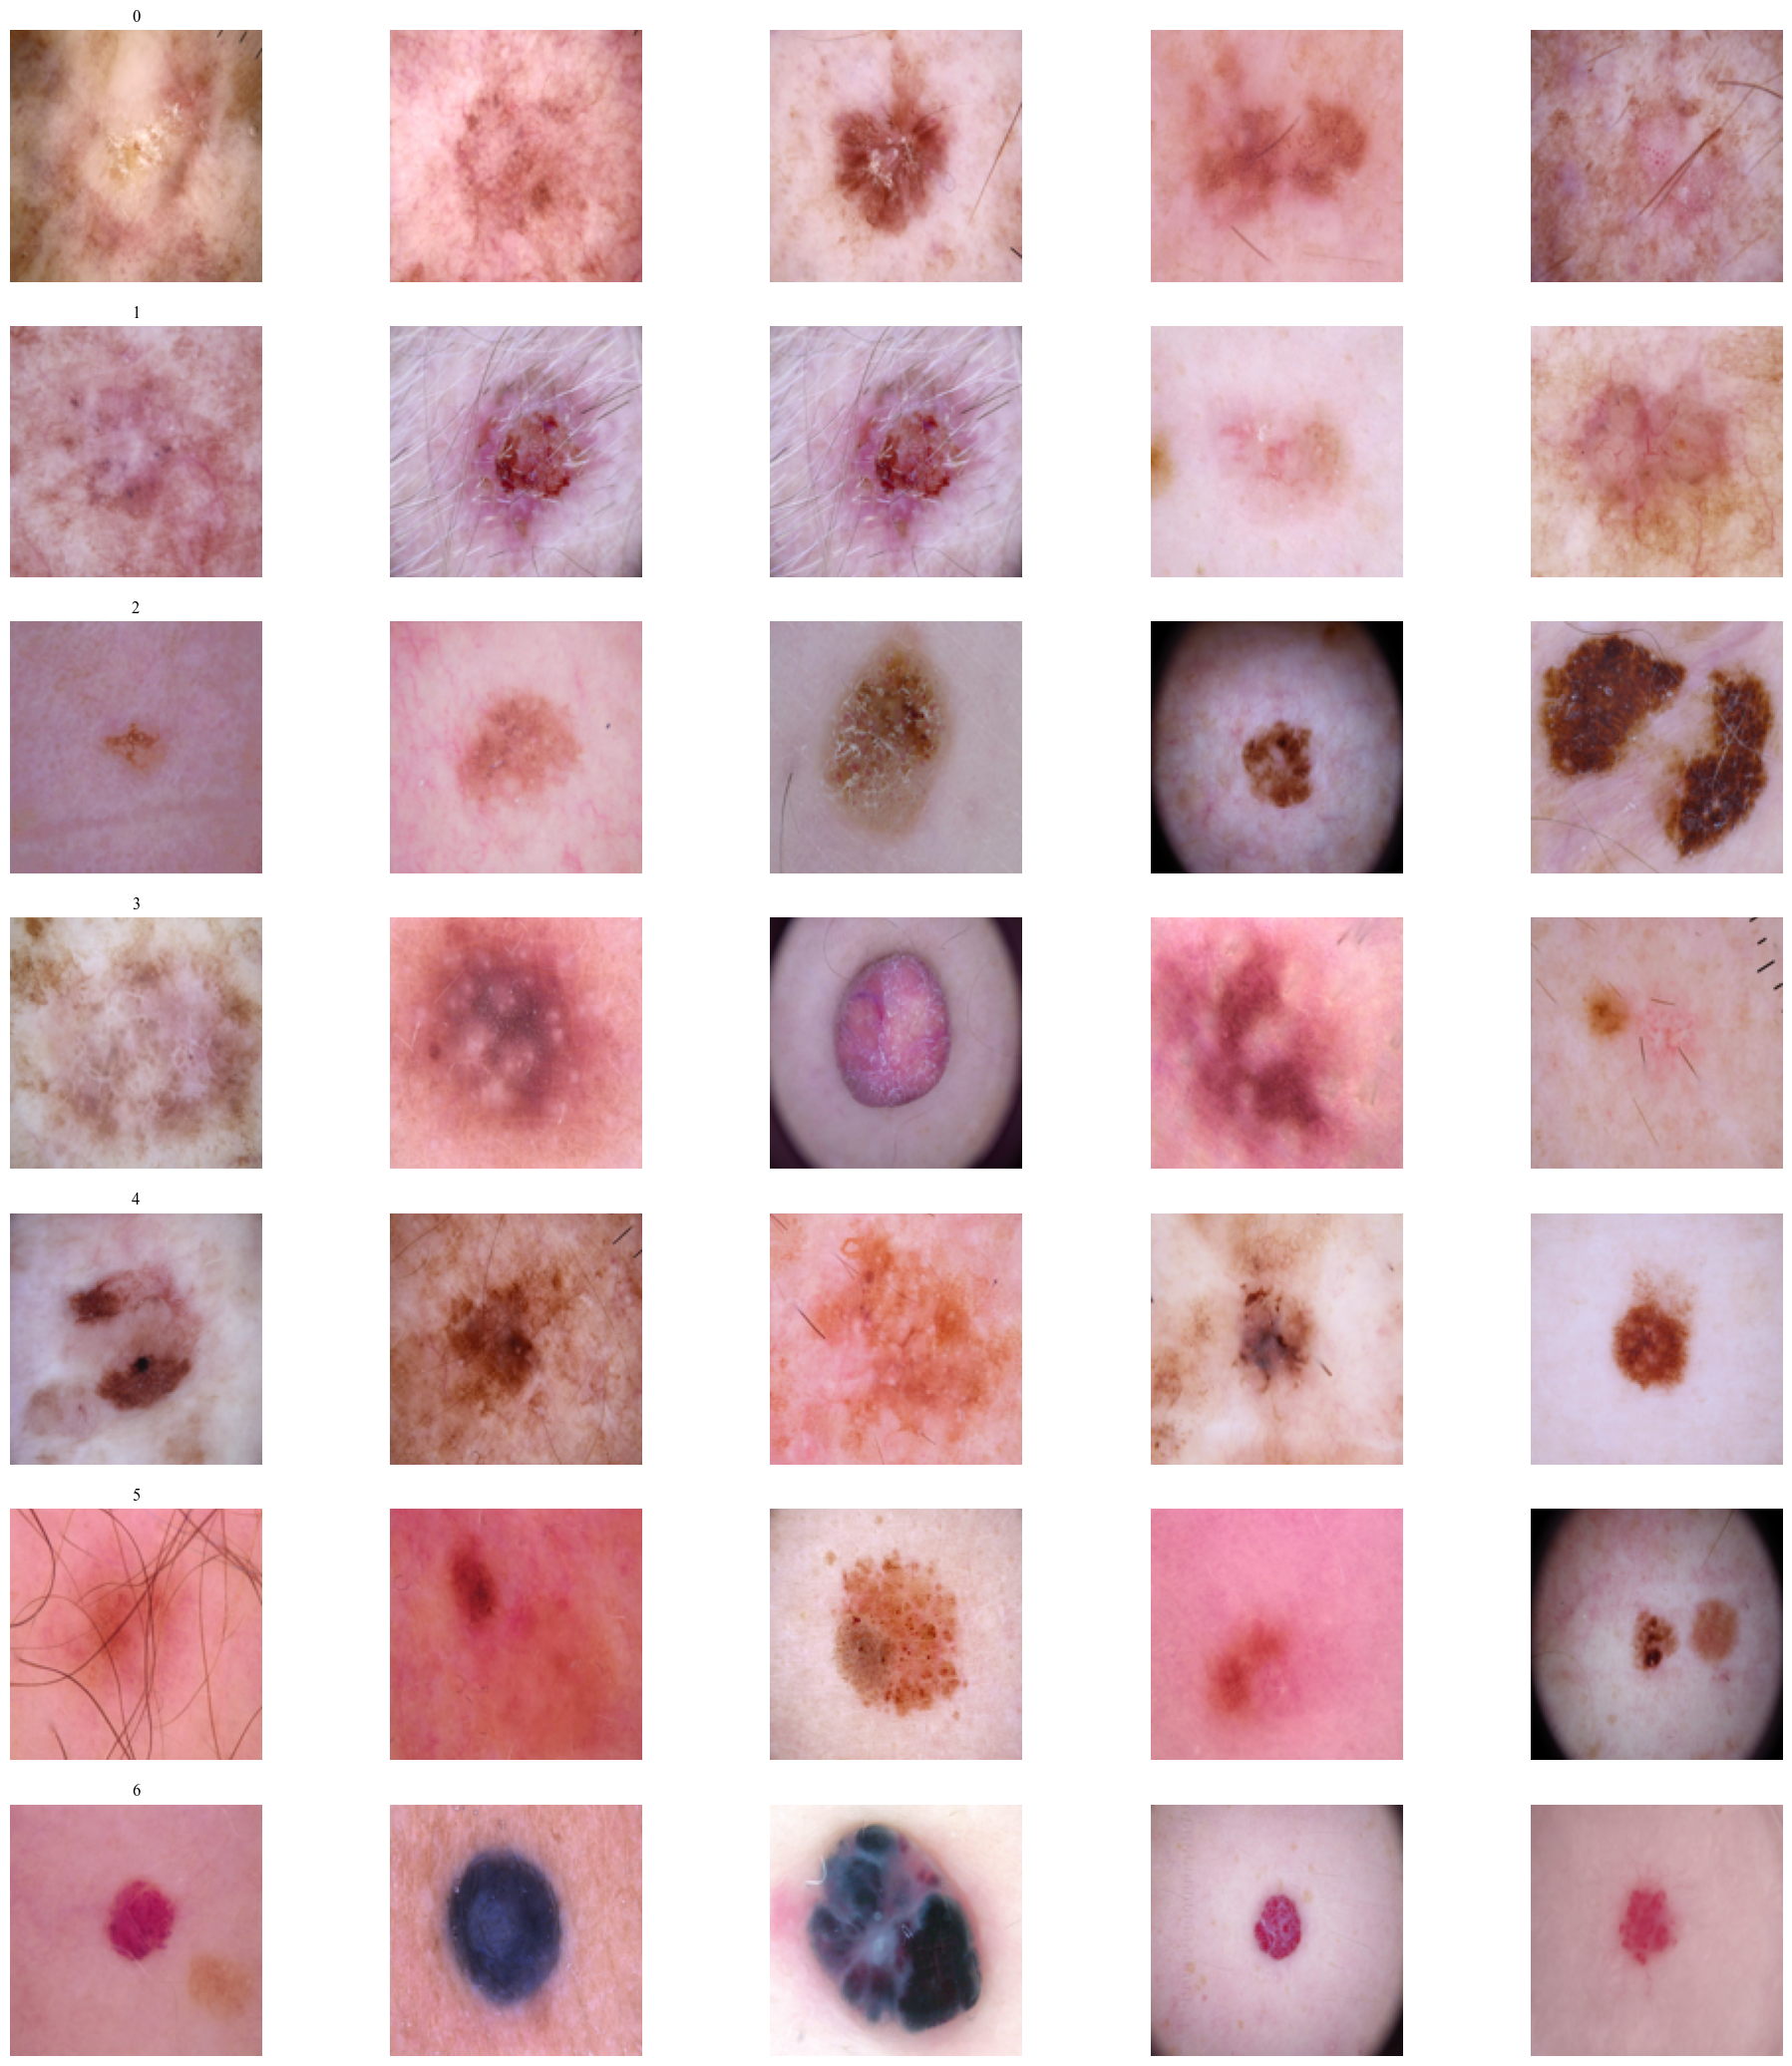

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from PIL import Image
import glob

# Ensure `skin_df` exists with the necessary columns
# 'label': Skin condition labels
# 'image_id': Unique identifier for each image

# Balance the dataset by resampling
max_samples = skin_df['label'].value_counts().max()
frac = 0.7  # Fraction of max_samples to use for resampling

skin_df_balanced = pd.DataFrame()
for label in skin_df['label'].unique():
    df_label = skin_df[skin_df['label'] == label]
    n_samples = min(len(df_label), int(max_samples * frac))
    df_label_balanced = resample(df_label, replace=True, n_samples=n_samples, random_state=42)
    skin_df_balanced = pd.concat([skin_df_balanced, df_label_balanced])

# Verify label distribution after balancing
print(skin_df_balanced['label'].value_counts())

# Create a mapping of image IDs to file paths
image_path = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob.glob(os.path.join(r'G:\Amrita University\Anomoly_image\Skin', '*', '*.jpg'))
}

# Map paths to image IDs in the balanced DataFrame
skin_df_balanced['path'] = skin_df_balanced['image_id'].map(image_path.get)

# Define the size for image resizing
SIZE = 128  # Resize to 128x128 or any other desired size

# Read and resize images; remove rows with missing paths
skin_df_balanced['image'] = skin_df_balanced['path'].map(
    lambda x: np.asarray(Image.open(x).resize((SIZE, SIZE))) if x else None
)
skin_df_balanced = skin_df_balanced.dropna(subset=['image'])  # Drop rows with missing images

# Number of samples to display per label
n_samples = 5

# Plot samples for each label
unique_labels = skin_df_balanced['label'].nunique()
fig, m_axs = plt.subplots(unique_labels, n_samples, figsize=(4 * n_samples, 3 * unique_labels))

for n_axs, (type_name, type_rows) in zip(m_axs, skin_df_balanced.groupby('label')):
    n_axs[0].set_title(type_name, fontsize=12)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

plt.tight_layout()
plt.show()

## Data preprocessing and splitting

In [38]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255. # Scale values to 0-1. You can also used standardscaler or other scaling methods.
Y=skin_df_balanced['label'] #Assign label values to Y
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
#Split to training and testing. Get a very small dataset for training as we will be 
# fitting it to many potential models. 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_cat, test_size=0.20, random_state=42)

## Normalization by stabdard deviation

In [ ]:
### Calculate mean
X_train_mean = np.mean(X_train)
X_train_std = np.std(X_train)

### Calculate standard deviation
X_test_mean = np.mean(X_test)
X_test_std = np.std(X_test)

## Normalization
X_train = (X_train - X_train_mean)/X_train_std
X_test = (X_test - X_test_mean)/X_test_std

## Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.12,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.12,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=True,  # randomly flip images
    shear_range=0.2,  # apply shear transformation
    channel_shift_range=0.5,  # randomly shift color channels
    brightness_range=[0.8, 1.2],  # randomly adjust brightness
    fill_mode='nearest'  # strategy for filling newly created pixels
)

datagen.fit(X_train)

## Example after augumentation

2024-12-01 15:32:52,993 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
2024-12-01 15:32:53,065 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


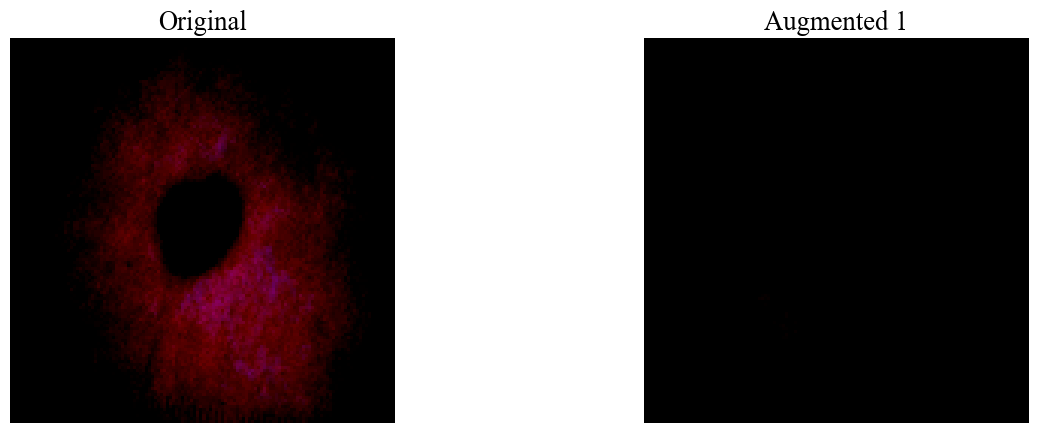

In [41]:
datagen.fit(X_train)
import matplotlib.pyplot as plt
import numpy as np

# Generate augmented images
augmented_images = []
num_samples = 1  # Number of augmented samples to generate

for i in range(num_samples):
    augmented_image = datagen.random_transform(X_train[3])  # Apply augmentation to the first image in your dataset
    augmented_images.append(augmented_image)

# Plot the original and augmented images
plt.figure(figsize=(15, 5))
for i in range(num_samples + 1):
    plt.subplot(1, num_samples + 1, i + 1)
    
    if i == 0:
        plt.imshow(X_train[3])
        plt.title('Original')
    else:
        plt.imshow(augmented_images[i - 1])
        plt.title(f'Augmented {i}')

    plt.axis('off')

plt.show()

## Esemble pre-trained with improvement of Autoencoder ## Skin cancer-7 classs

In [42]:
from tensorflow.keras.applications import ResNet101, VGG19
from tensorflow.keras.layers import concatenate, Input, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def get_model(input_shape, learning_rate=0.001, num_filters=32, filter_size=(3, 3), dropout_rate=0.25):
    input_tensor = Input(shape=input_shape)
    
    # Cast num_filters to int to ensure it's an integer value
    num_filters = int(num_filters)
    # Load ResNet50 and VGG19 as feature extractors
    resnet = ResNet101(weights='imagenet', include_top=False, input_shape=input_shape)
    vgg = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Ensure the pre-trained layers are not trainable
    for layer in resnet.layers:
        layer.trainable = False
    for layer in vgg.layers:
        layer.trainable = False

    # Define the input
    input_tensor = Input(shape=input_shape)

    # Use ResNet50 and VGG19
    resnet_features = resnet(input_tensor)
    vgg_features = vgg(input_tensor)

    # Concatenate the features
    combined_features = concatenate([resnet_features, vgg_features])

    # Start using 'combined_features' instead of 'x' as 'x' was incorrectly used before being defined
    x = Flatten()(combined_features)
    x = Dense(256)(x)  # Remove the activation parameter here
    x = LeakyReLU(alpha=0.25)(x)  # Correct usage of LeakyReLU
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128)(x)  # Remove the activation parameter here
    x = LeakyReLU(alpha=0.25)(x)  # Correct usage of LeakyReLU
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(64)(x)  # Remove the activation parameter here
    x = LeakyReLU(alpha=0.25)(x)  # Correct usage of LeakyReLU
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    
    x = Dense(32)(x)  # Remove the activation parameter here
    x = LeakyReLU(alpha=0.25)(x)  # Correct usage of LeakyReLU
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    # Decoder
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = UpSampling2D((2, 2))(x)
    x = Dropout(0.25)(x)

    # Second Encoder
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)
    
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Dropout(0.25)(x)


    # Flatten and Fully Connected Layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

   

    # Output Layer
    output_tensor = Dense(7, activation='softmax')(x)  # Assuming 2 classes

    # Create and Compile Model
    model = Model(inputs=input_tensor, outputs=output_tensor)
    model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=learning_rate), metrics=["accuracy"])

    return model

## Model compilation and learning rate

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
SIZE = 128  # Image dimensions (adjust if needed)
learning_rate = 0.00075  # Initial learning rate
dropout_rate = 0.25  # Dropout rate

# Ensure `get_model` is defined to return a compiled Keras model
model = get_model(input_shape=(SIZE, SIZE, 3), learning_rate=learning_rate, dropout_rate=dropout_rate)

# Define a learning rate reduction callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',    # Monitor validation loss
    factor=0.5,            # Reduce learning rate by half
    patience=3,            # Wait for 3 epochs without improvement
    verbose=1,             # Print updates
    min_lr=1e-6            # Minimum learning rate
)

## Fitting the model

In [44]:
history = model.fit(X_train, Y_train, epochs=100, batch_size=32, validation_data=(X_test, Y_test), callbacks=[learning_rate_reduction], verbose=1)

Epoch 1/100
72/72 [==============================] - 81s 954ms/step - loss: 2.3115 - accuracy: 0.3477 - val_loss: 1.8649 - val_accuracy: 0.5829 - lr: 7.5000e-04
Epoch 2/100
72/72 [==============================] - 69s 960ms/step - loss: 1.7215 - accuracy: 0.4751 - val_loss: 2.2331 - val_accuracy: 0.4660 - lr: 7.5000e-04
Epoch 3/100
72/72 [==============================] - 71s 986ms/step - loss: 1.4912 - accuracy: 0.5371 - val_loss: 1.5598 - val_accuracy: 0.5428 - lr: 7.5000e-04
Epoch 4/100
72/72 [==============================] - 88s 1s/step - loss: 1.3000 - accuracy: 0.5746 - val_loss: 1.3914 - val_accuracy: 0.5358 - lr: 7.5000e-04
Epoch 5/100
72/72 [==============================] - 76s 1s/step - loss: 1.1435 - accuracy: 0.6204 - val_loss: 1.0413 - val_accuracy: 0.6457 - lr: 7.5000e-04
Epoch 6/100
72/72 [==============================] - 129s 2s/step - loss: 1.0669 - accuracy: 0.6287 - val_loss: 1.0037 - val_accuracy: 0.6562 - lr: 7.5000e-04
Epoch 7/100
72/72 [=======================

## Training and testing plot

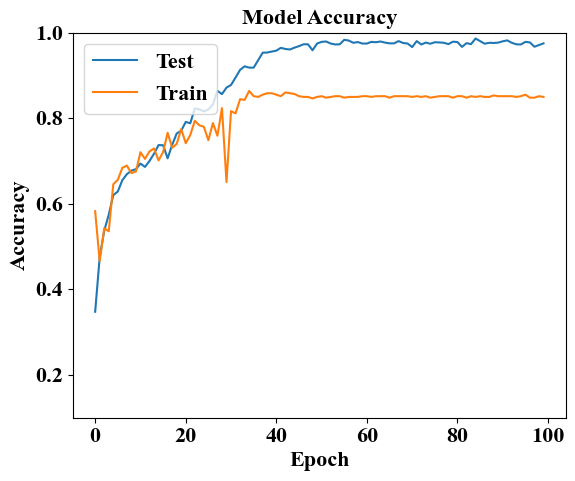

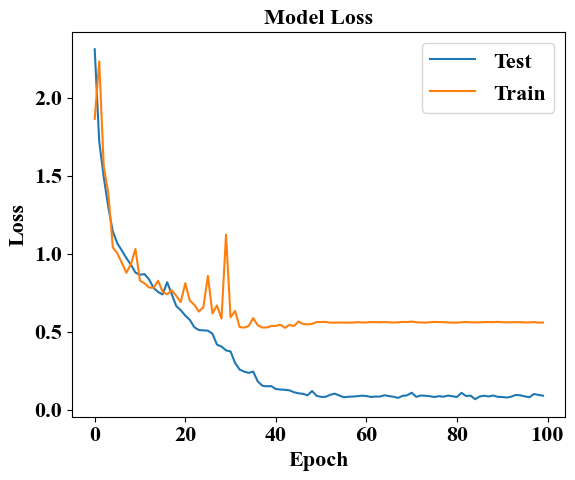

In [65]:
import matplotlib.pyplot as plt
import matplotlib
# Training Loss and Accuracy
training_loss = history.history['loss']
training_accuracy = history.history['accuracy']

#Validation (Test) Loss and Accuracy from the history object
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']

# Setting global parameters to ensure all text uses 'Times New Roman'
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.weight'] = 'bold'
matplotlib.rcParams['font.size'] = 16

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.ylabel('Accuracy', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.xlabel('Epoch', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
# Setting y-axis limits
plt.ylim([0.1, 1])
plt.legend(['Test', 'Train'], loc='upper left',  prop={'size': 16, 'weight': 'bold'})

# Plot training & validation loss values
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.ylabel('Loss', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.xlabel('Epoch', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.legend(['Test', 'Train'], loc='upper right', prop={'size': 16, 'weight': 'bold'})
plt.show()

## Confusion matrix

18/18 [==============================] - 4s 228ms/step


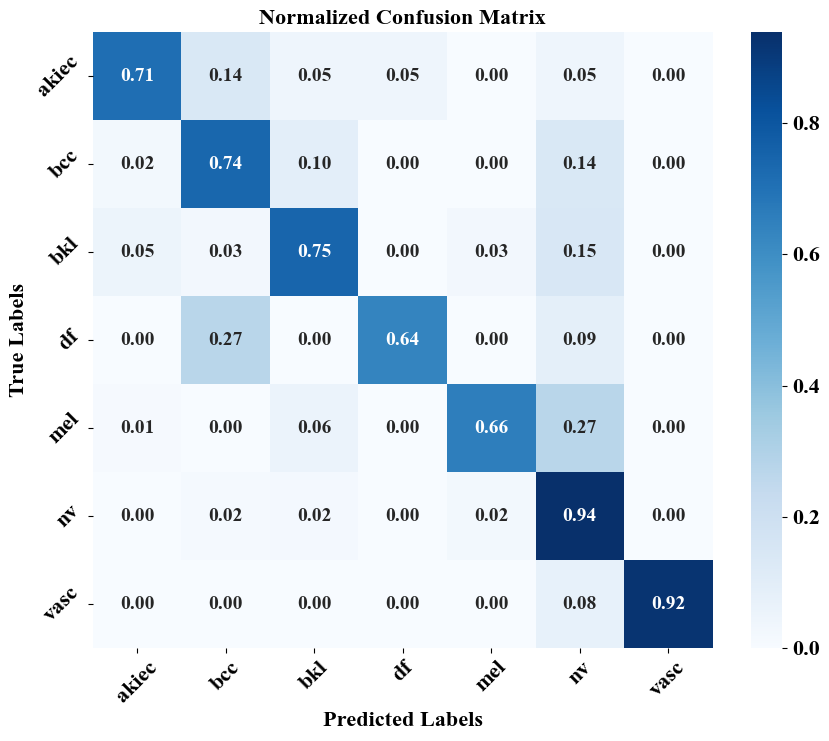

In [48]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your trained model and 'X_test', 'Y_test' are your test datasets

# Class labels
class_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

# Generate predictions
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)  # Convert probabilities to class indices
true_classes = np.argmax(Y_test, axis=1)  # Assuming Y_test is one-hot encoded; convert to class indices

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Visualize the normalized confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, annot_kws={"size": 14})
plt.title('Normalized Confusion Matrix', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.xlabel('Predicted Labels', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})
plt.ylabel('True Labels', fontdict={'fontsize': 16, 'fontweight': 'bold', 'family': 'Times New Roman'})

# Adjust font size and rotation of the tick labels
ax.tick_params(axis='x', labelsize=16, rotation=45)
ax.tick_params(axis='y', labelsize=16, rotation=45)

plt.show()

## F1 score

In [61]:
import pandas as pd
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

# Assuming true_classes and predicted_classes are defined
# Generate confusion matrix
cm = confusion_matrix(true_classes, predicted_classes, labels=[0, 1, 2, 3, 4, 5, 6])

# Define class labels
class_labels = [0, 1, 2, 3, 4, 5, 6]

# Calculate precision, recall, F1 score, and support for each class
precision, recall, f1_score, support = precision_recall_fscore_support(true_classes, predicted_classes, average=None, labels=class_labels)

# Sensitivity is the same as recall in this context
sensitivity = recall

# Calculate specificity for each class
def calculate_specificity(cm, label_index):
    true_negatives = cm.sum() - (cm[:, label_index].sum() + cm[label_index].sum() - cm[label_index, label_index])
    false_positives = cm[:, label_index].sum() - cm[label_index, label_index]
    specificity = true_negatives / (true_negatives + false_positives)
    return specificity

specificities = [calculate_specificity(cm, i) for i in range(len(class_labels))]

# Compile all metrics into a DataFrame
metrics_df = pd.DataFrame({
    'Class Label': class_labels,
    'Precision': precision,
    'Recall/Sensitivity': sensitivity,
    'F1 Score': f1_score,
    'Specificity': specificities,
    'Support': support
})

# Calculate the average F1 score
average_f1_score = f1_score.mean()



# Print the average F1 score
print("\nAverage F1 Score:", average_f1_score)


Average F1 Score: 0.7900172434369997


## Make predictions on a few test samples

In [ ]:
sample_predictions = model.predict(X_test[:10])
for i, prediction in enumerate(sample_predictions):
    print(f"Sample {i + 1} - Actual: {np.argmax(Y_test[i])}, Predicted: {np.argmax(prediction)}")

1/1 [==============================] - 0s 286ms/step
Sample 1 - Actual: 5, Predicted: 5
Sample 2 - Actual: 5, Predicted: 5
Sample 3 - Actual: 5, Predicted: 5
Sample 4 - Actual: 5, Predicted: 5
Sample 5 - Actual: 5, Predicted: 5
Sample 6 - Actual: 5, Predicted: 5
Sample 7 - Actual: 4, Predicted: 4
Sample 8 - Actual: 6, Predicted: 6
Sample 9 - Actual: 4, Predicted: 0
Sample 10 - Actual: 0, Predicted: 1


## Test on multiple images

2024-12-01 20:22:07,738 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 77ms/step
Image Index: 0


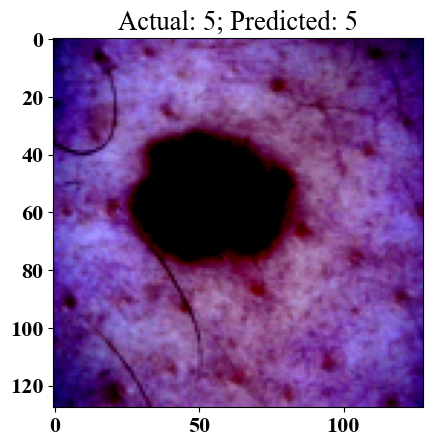

2024-12-01 20:22:08,857 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 41ms/step
Image Index: 1


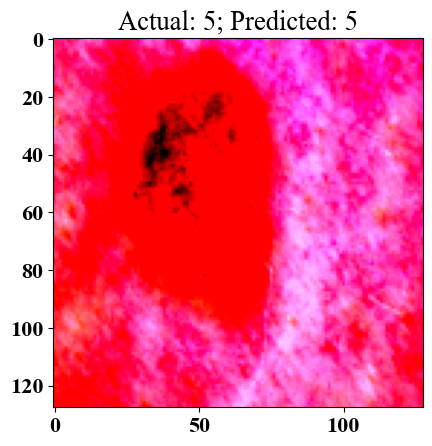

2024-12-01 20:22:09,669 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 61ms/step
Image Index: 2


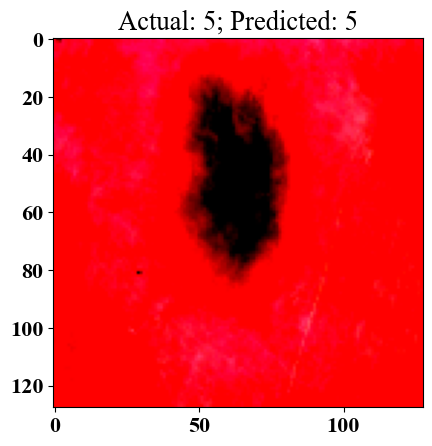

2024-12-01 20:22:10,526 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 64ms/step
Image Index: 3


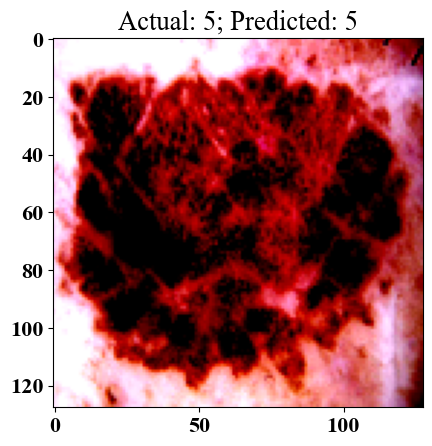

2024-12-01 20:22:11,470 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 140ms/step
Image Index: 4


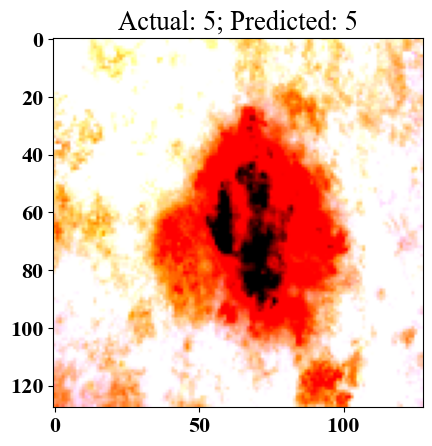

2024-12-01 20:22:12,611 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 45ms/step
Image Index: 5


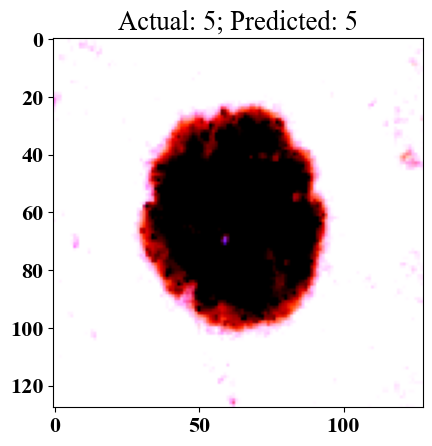

2024-12-01 20:22:13,322 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 45ms/step
Image Index: 6


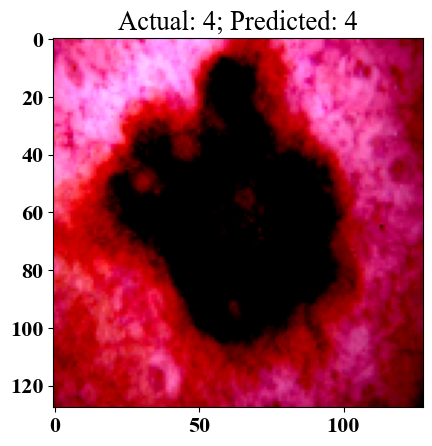

2024-12-01 20:22:14,185 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 38ms/step
Image Index: 7


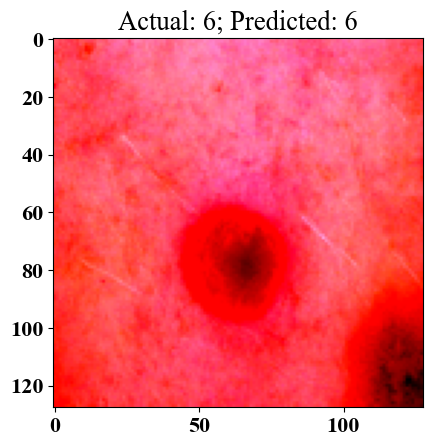

2024-12-01 20:22:14,978 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 49ms/step
Image Index: 8


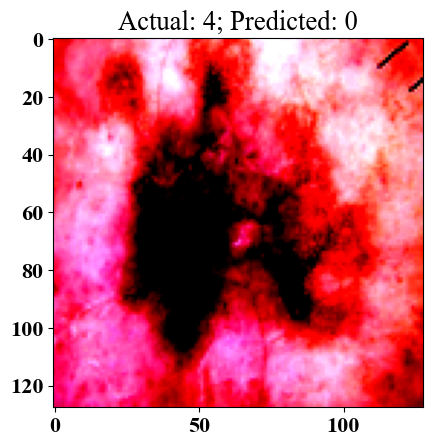

2024-12-01 20:22:15,943 - matplotlib.image - WARNING - Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 102ms/step
Image Index: 9


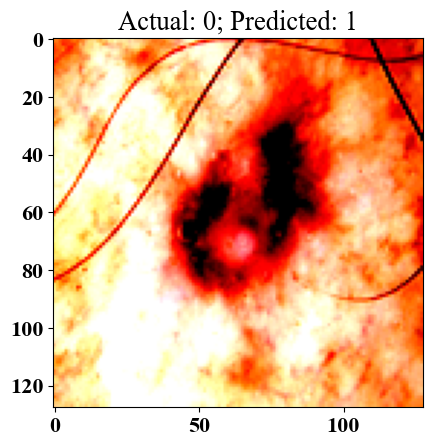

In [ ]:
num_images_to_show = 10  # Choose the number of images to display

for n in range(num_images_to_show):
    img = X_test[n]
    plt.imshow(img)
    
    input_img = np.expand_dims(img, axis=0)
    prediction = model.predict(input_img)
    
    # Get the actual and predicted labels
    actual_label = np.argmax(Y_test[n])
    predicted_label = np.argmax(prediction)
    
    print("Image Index:", n)
    # Set the title with actual and predicted labels side by side
    plt.title(f"Actual: {actual_label}; Predicted: {predicted_label}")
    
    plt.show()
    
    print("=" * 10)
